[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)

#### based on Example Figure from Pyrcel code documentation https://pyrcel.readthedocs.io/en/latest/examples/basic_run.html

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Pyrcel import Settings, Simulation
from PySDM_examples.Pyrcel.aerosol import AerosolMarine

from atmos_cloud_sim_uj_utils import show_plot

from PySDM.initialisation import spectra
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
from matplotlib import pylab

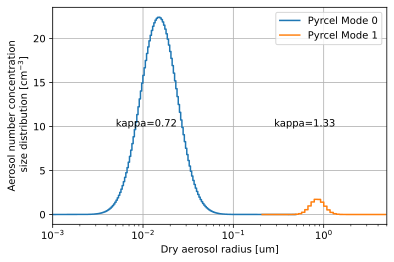

HTML(value="<a href='./size_dist.pdf' target='_blank'>./size_dist.pdf</a><br>")

In [3]:
aerosol = AerosolMarine()

for i in range(len(aerosol.aerosol_modes_per_cc)):
    spec = aerosol.aerosol_modes_per_cc[i]['spectrum']
    if i == 0:
        x_all = np.logspace(np.log(1 * si.nm), np.log(500 * si.nm), base=np.e, num=201)
    else:
        x_all = np.logspace(np.log(200 * si.nm), np.log(5000 * si.nm), base=np.e, num=41)
    dx = np.diff(x_all)
    x_mid = x_all[:-1] + dx/2
    pylab.step(x_mid / si.um, spec.size_distribution(x_mid)*dx / si.cm**-3, label=f"Pyrcel Mode {i}", where="mid")
    pylab.text(spec.m_mode/3 * si.m/si.um, 10, f"kappa={aerosol.aerosol_modes_per_cc[i]['kappa']:.2f}")
pylab.xlim(1e-3, 5e0)
pylab.xscale('log')
pylab.legend()
pylab.grid()
pylab.xlabel('Dry aerosol radius [um]')
pylab.ylabel('Aerosol number concentration\n size distribution [cm$^{-3}$]')
show_plot("size_dist.pdf")

In [4]:
output = {}
key = f"{aerosol.__class__.__name__}"
settings = Settings(
    dz=1*si.m,
    n_sd_per_mode=(200,40),
    aerosol=aerosol,
    spectral_sampling=spec_sampling.ConstantMultiplicity
)

simulation = Simulation(settings)
output[key] = simulation.run()
output[key]['color'] = aerosol.color

0 [4.01218363e-09 4.78289798e-09 5.23163765e-09 5.56901961e-09
 5.84706150e-09 6.08752488e-09 6.30178313e-09 6.49659808e-09
 6.67634732e-09 6.84404270e-09 7.00185344e-09 7.15139867e-09
 7.29392212e-09 7.43040197e-09 7.56162283e-09 7.68822472e-09
 7.81073728e-09 7.92960435e-09 8.04520201e-09 8.15785202e-09
 8.26783211e-09 8.37538389e-09 8.48071902e-09 8.58402416e-09
 8.68546487e-09 8.78518880e-09 8.88332830e-09 8.98000254e-09
 9.07531930e-09 9.16937645e-09 9.26226320e-09 9.35406113e-09
 9.44484514e-09 9.53468418e-09 9.62364190e-09 9.71177729e-09
 9.79914510e-09 9.88579632e-09 9.97177855e-09 1.00571363e-08
 1.01419113e-08 1.02261429e-08 1.03098681e-08 1.03931216e-08
 1.04759366e-08 1.05583444e-08 1.06403746e-08 1.07220556e-08
 1.08034143e-08 1.08844765e-08 1.09652668e-08 1.10458087e-08
 1.11261250e-08 1.12062374e-08 1.12861670e-08 1.13659340e-08
 1.14455579e-08 1.15250578e-08 1.16044519e-08 1.16837582e-08
 1.17629940e-08 1.18421761e-08 1.19213212e-08 1.20004452e-08
 1.20795641e-08 1.2158

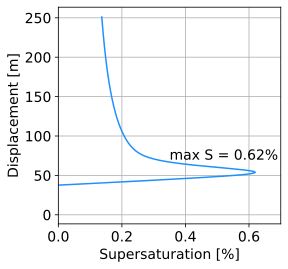

HTML(value="<a href='./supersaturation.pdf' target='_blank'>./supersaturation.pdf</a><br>")

In [5]:
pylab.rc('font', size=14)
fig, ax = pylab.subplots(1, 1, figsize=(4, 4), sharey=True)

var='S_max'
for key, out_item in output.items():
    Y = np.asarray(out_item['z'])
    ax.plot(out_item[var], Y, label=key, 
                  color=out_item['color'],
                  linestyle='-'
                 )
    peakSS = np.nanmax(out_item[var])

ax.set_ylabel('Displacement [m]')
ax.set_xlabel('Supersaturation [%]')
ax.set_xlim(0, 0.7)
ax.text(0.35,70,f"max S = {peakSS:.2f}%")
  
ax.grid()
show_plot("supersaturation.pdf")

dict_keys(['z', 't', 'S_max', 'n_c_cm3', 'wet size spectrum', 'dry size spectrum', 'color'])


Text(0, 0.5, 'Hydrometeor number concentration\n size distribution [mg$^{-1}$ μm$^{-1}$]')

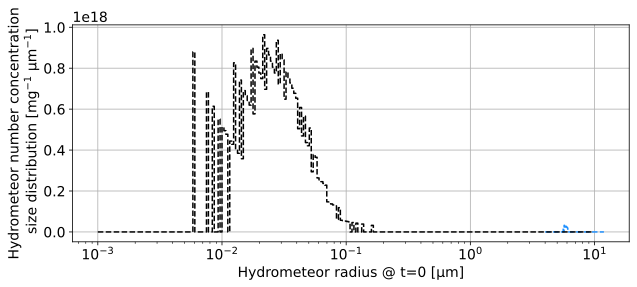

In [14]:
figsize = (10, 4)
pylab.rc('font', size=14)
fig, axs = pylab.subplots(1, 1, figsize=figsize, sharey=True)
for key, out_item in output.items():
    print(out_item.keys())
    pylab.step(
        settings.wet_radius_bins_edges[:-1] / si.um,
        out_item['wet size spectrum'][200],
        label=f'wet ({key})',
        color=out_item['color'],
        linestyle='-' if key.endswith('-bulk') else '--',
        where='pre'
    )
    pylab.step(
        settings.dry_radius_bins_edges[:-1] / si.um,
        out_item['dry size spectrum'][0],
        label=f'wet ({key})',
        color='k',
        linestyle='-' if key.endswith('-bulk') else '--',
        where='pre'
    )
pylab.xscale('log')
pylab.grid()
pylab.xlabel("Hydrometeor radius @ t=0 [μm]")
pylab.ylabel("Hydrometeor number concentration\n size distribution [mg$^{-1}$ μm$^{-1}$]")
# xticks = (4,5,6,7,8,9,10,11,12)
# axs.set_xticks(xticks)
# axs.set_xlim(xticks[0], xticks[-1])
# axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#show_plot()